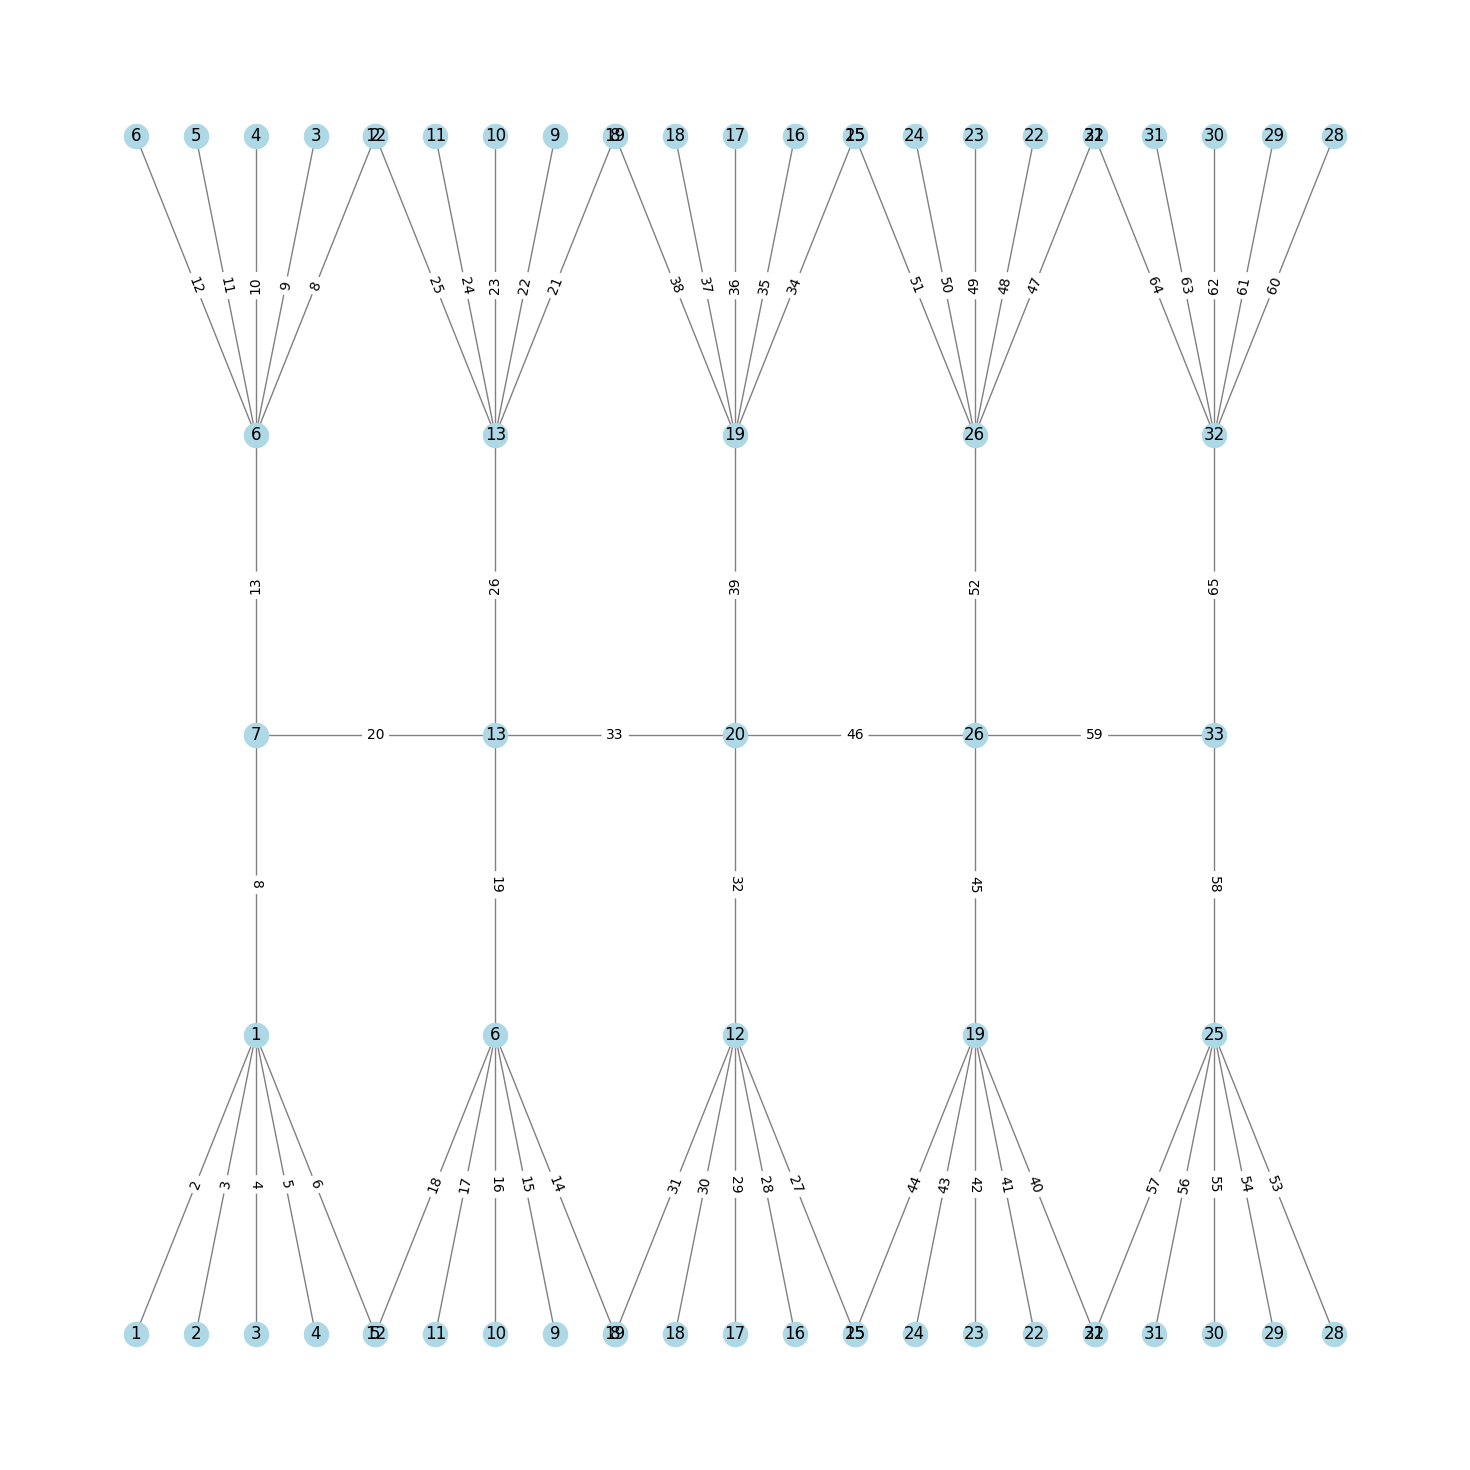

Number of vertices (V(G)):  65
Number of edges (E(G)):  64


In [48]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class ProceduralGraph:
    """
    A class representing a procedural graph, specifically designed to
    construct a Homogeneous lobster graph.

    Attributes:
        l (int): The length of the main path of the graph.
        d (int): The number of pendants attached to each centroid of the subgraph.
        h (int): The size of each subgraph.
        o (int): The order of the graph, which is the total number of nodes.
        V_w (numpy.ndarray): The array representing node weights.
        E_w (numpy.ndarray): The array representing edge weights.
        G (networkx.Graph): The graph object from NetworkX.
    """
    def __init__(self, l, d):
        """
        The constructor for the ProceduralGraph class.

        Parameters:
            l (int): The length of the main path of the graph.
            d (int): The number of pendants attached to each centroid of the subgraph.

        Raises:
            ValueError: If the number of pendants 'd' is less than 1.
        """
        # Validate that the number of pendants is at least 1
        if d < 1:
            raise ValueError('The number of pendants of the star must be at least 1')
        self.l = int(l)  # Initialize the length of the main path
        self.d = int(d)  # Initialize the number of pendants of each star
        self.h = 3 + self.d * 2  # Calculate the size of each subgraph
        self.o = self.l * self.h # Calculate the order of the graph (total number of nodes)
        # Initialize arrays for vertex and edge weights using int32 for memory efficiency
        self.V_w = np.empty(self.o, dtype=np.int32)
        self.E_w = np.empty(self.o, dtype=np.int32)
        # Create an instance of a graph
        self.G = nx.Graph()

    def generate_weights(self):
        """
        Generates node and edge weights for the Homogeneous lobster graph in a structured pattern.

        The method fills in the node and edge weight arrays with values based on the
        position and connection of each node in the main path and its associated pendants.

        Returns:
            tuple: A tuple containing the node weight array and the edge weight array.
        """
        # Loop through each node in the main path to generate weights
        for n in range(1, self.l + 1):
            # Calculate indices for the main path node and centroids
            prev_path_idx = (n-2) * self.h
            path_idx = (n-1) * self.h
            upper_centroid_idx = path_idx + 1
            lower_centroid_idx = upper_centroid_idx + self.d + 1

            # Assign weights to the main path node and its edges
            self.V_w[path_idx] = (n * self.h + 1) // 2
            self.E_w[path_idx] = self.V_w[path_idx] + self.V_w[prev_path_idx] if n > 1 else -1

            # Assign weights to the upper centroid and its edges
            self.V_w[upper_centroid_idx] = (n * self.h) // 2
            self.E_w[upper_centroid_idx] = self.V_w[path_idx] + self.V_w[upper_centroid_idx]

            # Assign weights to the upper pendants and their edges
            for i in range(self.d):
                pendant_idx = upper_centroid_idx + 1 + i
                self.V_w[pendant_idx] = (n * self.h - 1) // 2 - i
                self.E_w[pendant_idx] = self.V_w[upper_centroid_idx] + self.V_w[pendant_idx]

            # Assign weights to the lower centroid and its edges
            self.V_w[lower_centroid_idx] = self.V_w[prev_path_idx] - 1 if n > 1 else 1
            self.E_w[lower_centroid_idx] = self.V_w[lower_centroid_idx] + self.V_w[path_idx]

            # Assign weights to the lower pendants and their edges
            for i in range(self.d):
                pendant_idx = lower_centroid_idx + 1 + i
                self.V_w[pendant_idx] = (n * self.h - 1) // 2 - i if n > 1 else i + 1
                self.E_w[pendant_idx] = self.V_w[pendant_idx] + self.V_w[lower_centroid_idx]

        return self.V_w, self.E_w

    def draw_graph(self):
        """
        Draws the graph using matplotlib with the node weights and edge weights.

        If weights have not been generated yet, it calls `generate_weights` method.
        Positions for the nodes are calculated to visually represent the homogeneous
        lobster structure of the graph.
        """
        # Generate weights if they have not been generated yet
        if self.V_w[0] == 0 or self.E_w[0] == 0:
            self.V_w, self.E_w = self.generate_weights()

        # Custom positions dictionary for nodes
        pos = {}
        # Determine horizontal and vertical spacing for visual layout
        horizontal_spacing = max(2.0, 1.0 + 0.3 * self.d)
        vertical_spacing = 2.0
        # Set figure size for the plot
        plt.figure(figsize=(12 + 0.5 * self.l, 12 + 0.5 * self.d))

        # Add nodes with their weights and positions
        for n in range(1, self.l + 1):
            path_x_position = n * horizontal_spacing
            path_idx = (n - 1) * self.h
            # Set position for the main path node
            pos[path_idx] = (path_x_position, 0)
            self.G.add_node(path_idx, weight=self.V_w[path_idx])
            # Connect the main path nodes
            if n != 1:
                prev_path_idx = (n - 2) * self.h
                self.G.add_edge(path_idx, prev_path_idx, weight=self.V_w[path_idx] + self.V_w[prev_path_idx])

            # Set positions for centroids and connect them to the main path node
            for is_upper in [True, False]:
                centroid_offset = 1 if is_upper else self.d + 2
                pendant_y_position = vertical_spacing if is_upper else -vertical_spacing
                centroid_idx = path_idx + centroid_offset
                pos[centroid_idx] = (path_x_position, pendant_y_position)
                self.G.add_node(centroid_idx, weight=self.V_w[centroid_idx])
                self.G.add_edge(path_idx, centroid_idx, weight=self.V_w[centroid_idx] + self.V_w[path_idx])

                # Set positions for pendants and connect them to their respective centroids
                for i in range(self.d):
                    pendant_idx = centroid_idx + i + 1
                    pendant_x_position = path_x_position - 0.5 * horizontal_spacing + i * horizontal_spacing / (self.d - 1)
                    pos[pendant_idx] = (pendant_x_position, 2 * pendant_y_position)
                    self.G.add_node(pendant_idx, weight=self.V_w[pendant_idx])
                    self.G.add_edge(pendant_idx, centroid_idx, weight=self.V_w[centroid_idx] + self.V_w[pendant_idx])

        # Draw the graph with edge labels for weights
        edge_labels = nx.get_edge_attributes(self.G, 'weight')
        node_labels = nx.get_node_attributes(self.G, 'weight')
        nx.draw(self.G, pos, with_labels=False, node_color='lightblue', edge_color='gray')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)
        nx.draw_networkx_labels(self.G, pos, labels=node_labels)

        plt.show()

    def count_vertices_and_edges(self):
        """
        Counts and prints the number of vertices and edges in the graph.
        """
        # Count vertices and edges
        V_G = self.o
        E_G = self.G.number_of_edges()
        # Print the counts
        print("Number of vertices (V(G)): ", V_G)
        print("Number of edges (E(G)): ", E_G)

# Create an instance of the graph with specified length and number of pendants
graph = ProceduralGraph(l=5, d=5)
# Generate the weights for the vertices and edges
graph.generate_weights()
# Draw the graph
graph.draw_graph()
# Count and print the number of vertices and edges
graph.count_vertices_and_edges()
